## 问题

With over 1,200 quick service restaurants across the globe, TFI is the company behind some of the world's most well-known brands: Burger King, Sbarro, Popeyes, Usta Donerci, and Arby’s. They employ over 20,000 people in Europe and Asia and make significant daily investments in developing new restaurant sites.

Right now, deciding when and where to open new restaurants is largely a subjective process based on the personal judgement and experience of development teams. This subjective data is difficult to accurately extrapolate across geographies and cultures. 

New restaurant sites take large investments of time and capital to get up and running. When the wrong location for a restaurant brand is chosen, the site closes within 18 months and operating losses are incurred. 

Finding a mathematical model to increase the effectiveness of investments in new restaurant sites would allow TFI to invest more in other important business areas, like sustainability, innovation, and training for new employees. Using demographic, real estate, and commercial data, this competition challenges you to predict the annual restaurant sales of 100,000 regional locations.

## 数据

+ Id : Restaurant id. 
+ Open Date : opening date for a restaurant
+ City : City that the restaurant is in. Note that there are unicode in the names. 
+ City Group: Type of the city. Big cities, or Other. 
+ Type: Type of the restaurant. FC: Food Court, IL: Inline, DT: Drive Thru, MB: Mobile
+ P1, P2 - P37: There are three categories of these obfuscated data. Demographic data are gathered from third party providers with GIS systems. These include population in any given area, age and gender distribution, development scales. Real estate data mainly relate to the m2 of the location, front facade of the location, car park availability. Commercial data mainly include the existence of points of interest including schools, banks, other QSR operators.
+ Revenue: The revenue column indicates a (transformed) revenue of the restaurant in a given year and is the target of predictive analysis. Please note that the values are transformed so they don't mean real dollar values. 


In [123]:
import pandas as pd
import numpy as np
from matplotlib import pylab
import matplotlib.pyplot as plt
import datetime

from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import (GridSearchCV, RandomizedSearchCV)
from sklearn.metrics import (mean_squared_error, mean_absolute_error)
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import ExtraTreesClassifier # 插值用

from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge 

%matplotlib inline

In [99]:
#Random Seed
SEED = 0
train = pd.read_csv('../data/restaurant/train.csv', index_col = 0, parse_dates=[1])
test = pd.read_csv('../data/restaurant/test.csv', index_col = 0, parse_dates=[1])
print("Train Dimensions:")
print(train.shape)
print("Test Dimensions:")
print(test.shape)

Train Dimensions:
(137, 42)
Test Dimensions:
(100000, 41)


In [100]:
# 测试集里面有fake数据，真实和虚假数据比例 1:311.5
FAKE_DATA_RATIO = 311.5

In [101]:
train.head()

,Open Date,City,City Group,Type,P1,P2,P3,P4,P5,P6,...,P29,P30,P31,P32,P33,P34,P35,P36,P37,revenue
Id,,,,,,,,,,,,,,,,,,,,,
0,1999-07-17,İstanbul,Big Cities,IL,4,5.0,4.0,4.0,2,2,...,3.0,5,3,4,5,5,4,3,4,5653753.0
1,2008-02-14,Ankara,Big Cities,FC,4,5.0,4.0,4.0,1,2,...,3.0,0,0,0,0,0,0,0,0,6923131.0
2,2013-03-09,Diyarbakır,Other,IL,2,4.0,2.0,5.0,2,3,...,3.0,0,0,0,0,0,0,0,0,2055379.0
3,2012-02-02,Tokat,Other,IL,6,4.5,6.0,6.0,4,4,...,7.5,25,12,10,6,18,12,12,6,2675511.0
4,2009-05-09,Gaziantep,Other,IL,3,4.0,3.0,4.0,2,2,...,3.0,5,1,3,2,3,4,3,3,4316715.0


In [102]:
# 连接训练和测试数据后来进行预处理
df = pd.concat((test, train), ignore_index=True)
df.describe()

,P1,P10,P11,P12,P13,P14,P15,P16,P17,P18,...,P35,P36,P37,P4,P5,P6,P7,P8,P9,revenue
count,100137.000000,100137.000000,100137.000000,100137.000000,100137.000000,100137.000000,100137.000000,100137.000000,100137.000000,100137.000000,...,100137.000000,100137.000000,100137.000000,100137.000000,100137.000000,100137.000000,100137.000000,100137.000000,100137.000000,1.370000e+02
mean,4.087930,5.459011,3.311653,5.061765,5.086621,1.280276,1.305641,1.747336,1.156715,1.708789,...,1.833099,1.969222,0.973696,4.395992,1.989614,2.882551,5.300678,4.931304,5.251645,4.453533e+06
std,2.813085,1.763709,2.067903,1.765647,0.979414,2.497106,2.167272,3.172481,2.432137,3.030907,...,3.229052,3.806280,1.677427,1.035796,1.065518,1.532502,2.178739,1.718699,1.702825,2.576072e+06
min,1.000000,4.000000,1.000000,2.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,2.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.149870e+06
25%,2.000000,5.000000,2.000000,4.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,4.000000,1.000000,2.000000,5.000000,4.000000,4.000000,2.999068e+06
50%,3.000000,5.000000,3.000000,5.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,4.000000,2.000000,2.000000,5.000000,5.000000,5.000000,3.939804e+06
75%,4.000000,5.000000,4.000000,5.000000,5.000000,2.000000,2.000000,3.000000,2.000000,4.000000,...,4.000000,3.000000,2.000000,5.000000,2.000000,4.000000,5.000000,5.000000,5.000000,5.166635e+06
max,15.000000,10.000000,10.000000,10.000000,7.500000,15.000000,10.000000,15.000000,15.000000,15.000000,...,15.000000,20.000000,8.000000,7.500000,8.000000,10.000000,10.000000,10.000000,10.000000,1.969694e+07


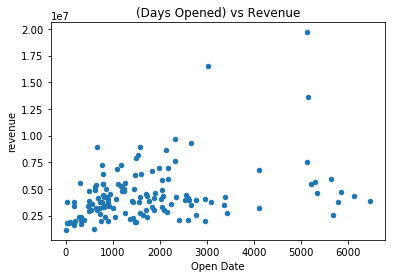

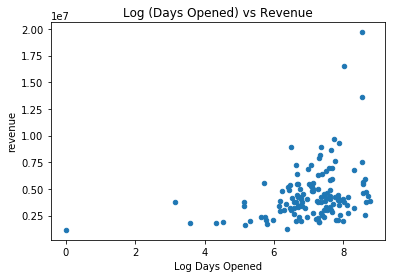

In [103]:
# 时间数据转换为开业天数
df["Open Date"] = df["Open Date"].apply(pd.to_datetime)
last_date = df["Open Date"].max()
df["Open Date"] = last_date - df["Open Date"] 
df["Open Date"] = df["Open Date"].dt.days + 1 
df[["Open Date", "revenue"]].plot(x="Open Date", y="revenue", kind='scatter', title="(Days Opened) vs Revenue")
#进行一次log 变换，降低open date的影响
df["Log Days Opened"] = df["Open Date"].apply(np.log)
df = df.drop(["Open Date"], axis=1)
#pylab.rcParams['figure.figsize'] = (8, 6) 
plt.figure(figsize = (8, 6))
df[["Log Days Opened", "revenue"]].plot(x="Log Days Opened", y="revenue", kind='scatter', title="Log (Days Opened) vs Revenue")

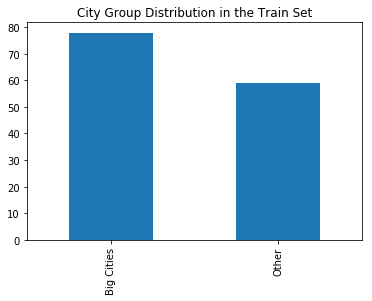

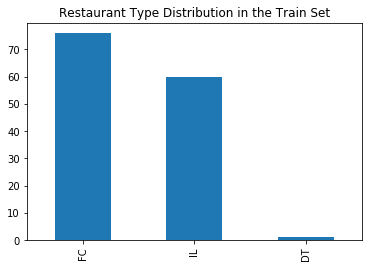

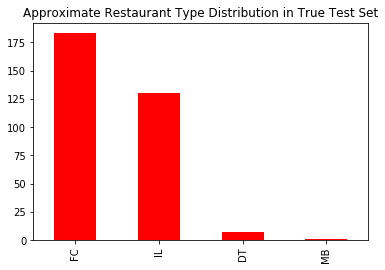

In [104]:
# Here we convert two categorical variables, "Restaurant Type" and "City Group (Size)" 
# to dummy variables
plt.figure(figsize = (6, 4))
# 城市类型
train["City Group"].value_counts().plot(title="City Group Distribution in the Train Set", kind='bar')
plt.figure(figsize = (6, 4))
# 餐厅类型
train["Type"].value_counts().plot(title="Restaurant Type Distribution in the Train Set", kind='bar')
plt.figure(figsize = (6, 4))
# 测试集，这里除了一个虚构数据比率
(test["Type"].value_counts() / FAKE_DATA_RATIO).plot(title="Approximate Restaurant Type Distribution in True Test Set", kind='bar', color='Red')

可能对于餐厅类型DT, MB预测没有意义，数据量太小

In [105]:
df = df.join(pd.get_dummies(df['City Group'], prefix="CG"))
df = df.join(pd.get_dummies(df['Type'], prefix="T"))

df.columns

Index(['City', 'City Group', 'P1', 'P10', 'P11', 'P12', 'P13', 'P14', 'P15',
       'P16', 'P17', 'P18', 'P19', 'P2', 'P20', 'P21', 'P22', 'P23', 'P24',
       'P25', 'P26', 'P27', 'P28', 'P29', 'P3', 'P30', 'P31', 'P32', 'P33',
       'P34', 'P35', 'P36', 'P37', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'Type',
       'revenue', 'Log Days Opened', 'CG_Big Cities', 'CG_Other', 'T_DT',
       'T_FC', 'T_IL', 'T_MB'],
      dtype='object')

In [106]:
# dummies转换后实际只需要n-1列
df = df.drop(["City Group", "Type", "CG_Other", "T_MB", "T_DT"], axis=1)
print(df.shape)

(100137, 43)


In [109]:
len(df['City'].unique()) #可以考虑如何处理...

63

In [110]:
# 利用FC和IL餐厅数据来对别的类型进行插值，这里注意只用了训练集
tofit = df.ix[((df.T_FC==1) | (df.T_IL==1)) & (pd.notnull(df.revenue))]
# 取除了FC,IL类型外的数据
tofill = df.ix[((df.T_FC==0) & (df.T_IL==0))]

print("type training set shape:", tofit.shape)
print("data to impute:", tofill.shape)

# 目标是判断餐厅类型为FC还是IL，FC=1，IL=0
y = tofit.T_FC
# 用其余数据来完成预测,revenue要去掉
X = tofit.drop(["T_FC", "T_IL", "revenue","City"], axis=1)

type training set shape: (136, 43)
data to impute: (2535, 43)


In [111]:
X.columns

Index(['P1', 'P10', 'P11', 'P12', 'P13', 'P14', 'P15', 'P16', 'P17', 'P18',
       'P19', 'P2', 'P20', 'P21', 'P22', 'P23', 'P24', 'P25', 'P26', 'P27',
       'P28', 'P29', 'P3', 'P30', 'P31', 'P32', 'P33', 'P34', 'P35', 'P36',
       'P37', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'Log Days Opened',
       'CG_Big Cities'],
      dtype='object')

In [112]:
# 定义一个判断餐厅类型的模型，通过grid search来搜索超参数
model_grid = {'max_depth': [None, 8], 'min_samples_split': [4,9,16], 'min_samples_leaf':[1,4], 'max_features':['sqrt', 0.5, None]}
type_model = ExtraTreesClassifier(n_estimators=25, random_state=SEED)

grid = RandomizedSearchCV(type_model, model_grid, n_iter=10, cv=5, scoring="roc_auc")
grid.fit(X, y)

print("Best parameters for Type Model:")
print(grid.best_params_)

type_model.set_params(**grid.best_params_)
type_model.fit(X, y)

Best parameters for Type Model:
{'max_features': 0.5, 'min_samples_split': 16, 'min_samples_leaf': 1, 'max_depth': 8}


ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=8, max_features=0.5, max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=16, min_weight_fraction_leaf=0.0,
           n_estimators=25, n_jobs=1, oob_score=False, random_state=0,
           verbose=0, warm_start=False)

In [113]:
#插值
imputations = type_model.predict(tofill.drop(["T_FC", "T_IL", "revenue","City"], axis=1))
df.loc[(df.T_FC==0) & (df.T_IL==0), "T_FC"] = imputations
#两种类型，我们用一列数据就可以了
df = df.drop(["T_IL"], axis=1)

print("% labeled FC in the training set:", df.T_FC.mean())
print("% of imputed values labeled FC:", np.mean(imputations))

% labeled FC in the training set: 0.586646294576
% of imputed values labeled FC: 0.650887573964


In [114]:
# binarize the "P" columns with dummy variables
print("Pre-binarizing columns:", len(df.columns))
for col in df.columns:
    if col[0] == 'P':
        print(col, len(df[col].unique()), "unique values")
        df = df.join(pd.get_dummies(df[col], prefix=col))
        df = df.drop([col, df.columns[-1]], axis=1)
print("Post-binarizing columns:", len(df.columns))

Pre-binarizing columns: 42
P1 9 unique values
P10 4 unique values
P11 8 unique values
P12 7 unique values
P13 5 unique values
P14 10 unique values
P15 9 unique values
P16 10 unique values
P17 10 unique values
P18 9 unique values
P19 9 unique values
P2 9 unique values
P20 9 unique values
P21 9 unique values
P22 5 unique values
P23 9 unique values
P24 9 unique values
P25 9 unique values
P26 10 unique values
P27 10 unique values
P28 9 unique values
P29 8 unique values
P3 8 unique values
P30 10 unique values
P31 10 unique values
P32 10 unique values
P33 7 unique values
P34 11 unique values
P35 8 unique values
P36 10 unique values
P37 8 unique values
P4 7 unique values
P5 7 unique values
P6 8 unique values
P7 7 unique values
P8 8 unique values
P9 5 unique values
Post-binarizing columns: 278


In [115]:
# 数据标准化处理
min_max_scaler = MinMaxScaler()
# revenue是target，不处理
rev = df.revenue
df = df.drop(['revenue',"City"], axis=1)

df = pd.DataFrame(data = min_max_scaler.fit_transform(df), columns = df.columns, index=df.index)
df = df.join(rev)

df.describe()

,Log Days Opened,CG_Big Cities,T_FC,P1_1,P1_2,P1_3,P1_4,P1_5,P1_6,P1_9,...,P8_3,P8_4,P8_5,P8_6,P8_8,P9_4,P9_5,P9_6,P9_8,revenue
count,100137.000000,100137.000000,100137.000000,100137.000000,100137.000000,100137.000000,100137.000000,100137.000000,100137.000000,100137.000000,...,100137.000000,100137.000000,100137.000000,100137.000000,100137.000000,100137.000000,100137.000000,100137.000000,100137.000000,1.370000e+02
mean,0.803995,0.492825,0.586646,0.051989,0.224752,0.228447,0.282912,0.068566,0.040924,0.024906,...,0.061745,0.381507,0.393970,0.015888,0.065620,0.351429,0.499396,0.003066,0.065271,4.453533e+06
std,0.124607,0.499951,0.492438,0.222005,0.417421,0.419834,0.450416,0.252716,0.198115,0.155839,...,0.240694,0.485759,0.488631,0.125044,0.247618,0.477419,0.500002,0.055285,0.247004,2.576072e+06
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.149870e+06
25%,0.735570,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.999068e+06
50%,0.822789,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.939804e+06
75%,0.886367,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,5.166635e+06
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.969694e+07


In [116]:
# 把数据重新分开，还原为原来的训练和测试数据
train = df.ix[pd.notnull(df.revenue)]
test = df.ix[pd.isnull(df.revenue)].drop(['revenue'], axis=1)

In [117]:
df[['revenue']].describe()

,revenue
count,1.370000e+02
mean,4.453533e+06
std,2.576072e+06
min,1.149870e+06
25%,2.999068e+06
50%,3.939804e+06
75%,5.166635e+06
max,1.969694e+07


In [118]:
# 变换revenue
y = train.revenue.apply(np.sqrt)
X = train.drop(["revenue"], axis=1)

In [119]:
# 使用Ridge模型来试验，当然其他SVR,RandomForest, GBT都可以
model_grid = [{'normalize': [True, False], 'alpha': np.logspace(0,10)}]
model = Ridge()

grid = GridSearchCV(estimator=model, param_grid=model_grid, scoring='neg_mean_squared_error',cv=LeaveOneOut())
grid.fit(X, y)
print("Best parameters set found on development set:")
print(grid.best_params_)

# 用最佳参数
model.set_params(**grid.best_params_)
model.fit(X, y)

Best parameters set found on development set:
{'alpha': 4.0949150623804256, 'normalize': True}


Ridge(alpha=4.0949150623804256, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=True, random_state=None, solver='auto',
   tol=0.001)

In [120]:
# 预测测试集
submission = pd.DataFrame(columns=['Prediction'],index=test.index, data=model.predict(test))
# 平方
submission.Prediction = submission.Prediction.apply(np.square)
# 提交需要id
submission.index.name='Id'

submission.to_csv("../data/restaurant/TFI_Ridge.csv")
submission.describe().astype(int)

,Prediction
count,100000
mean,4308653
std,637860
min,2229922
25%,3890075
50%,4247483
75%,4645573
max,8852164


In [121]:
#训练集
train[['revenue']].describe().astype(int)

,revenue
count,137
mean,4453532
std,2576071
min,1149870
25%,2999068
50%,3939804
75%,5166635
max,19696939


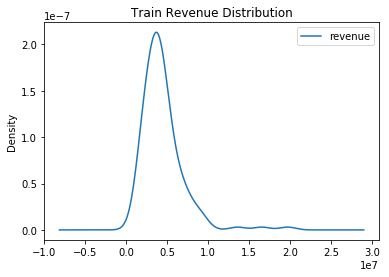

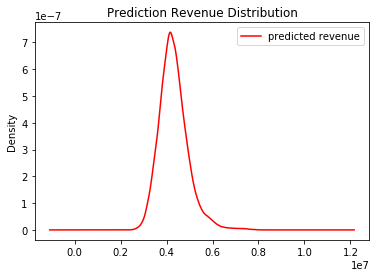

In [122]:
# 测试集结果明显比训练数据预测结果要低
train[['revenue']].plot(kind='kde', title="Train Revenue Distribution")
submission.columns = ["predicted revenue"]
submission.plot(kind='kde', title="Prediction Revenue Distribution", color='r')